### Sections

1. Imports
2. Helper Function
3. 2D Chaotic Map
4. Encoding Algorithm
5. Analysis
6. Implementation

# 1. Imports

In [12]:
from PIL import Image
import numpy as np
import cv2
from pylfsr import LFSR
from skimage import io
from matplotlib import pyplot as plt 

# 2.  Helper Functions

2.1 Any type to Binary Converter


In [13]:
def convertToBinary(data):
    if isinstance(data, str):
        return ''.join([ format(ord(i), "08b") for i in data ])
    elif isinstance(data, bytes) or isinstance(data, np.ndarray):
        return [ format(i, "08b") for i in data ]
    elif isinstance(data, int) or isinstance(data, np.uint8):
        return format(data, "08b")
    else:
        raise TypeError("Type not supported.")

2.2 Binary to Decimal Converter

In [14]:
def binaryToDecimal(binary):
    decimal = 0
    for bit in binary:
        decimal = decimal*2 + int(bit)
    return decimal

# 3.  2D Chaotic Map

- Hennon Map (Binary)

In [15]:
def HennonMapBinary(dimension, key):

    rows = dimension[0]
    cols = dimension[1]
    x = key[0]
    y = key[1]
    a = 1.4
    b = 0.3

    # Total Number of bitSequence produced
    sequenceSize = rows * cols
    bitSequenceSize = cols
    # Each bitSequence contains k bits
    bitSequence = []       
    # Each matrix contains m*n byteArray
    matrix = []

    for i in range(sequenceSize):
        x_next = y + 1 - (a * (x**2)) 
        y_next = b * x
        x = x_next
        y = y_next
        if x <= 0.4:
            bit = 0
        else:
            bit = 1

        bitSequence.append(bit) 

        # If Bit Sequence has k bits, convert it to decimal and add it to Byte Sequence.
        if i % bitSequenceSize == bitSequenceSize - 1:
            matrix.append(bitSequence)
            bitSequence = []

    return matrix

# 4. Encoding


In [16]:
def encode(videoname, filename, hennonKey, poly):

    # Divide video into frames
    vidObj = cv2.VideoCapture(videoname) 
    success = True
    frames = []
    while success: 
        success, image = vidObj.read()
        frames.append(image)

    fps = vidObj.get(cv2.CAP_PROP_FPS)

    # Get the video's width and height.
    imageWidth = int(vidObj.get(3))
    imageHeight = int(vidObj.get(4))

    vidObj.release()

    frame_usage = [0 for i in range(len(frames))]
    
    # Set Limit
    frame_size = (len(frames[0]), len(frames[0][0]))
    frame_usage_limit = (frame_size[0] * frame_size[1] * 3) * 0.3

    # Get secret data
    filehandler = open(filename,"r")
    secret_data = "".join(filehandler.readlines())
    secret_data += "=!"

    # convert data to binary
    binary_secret_data = convertToBinary(secret_data)
    data_len = len(binary_secret_data)

    data_index = 0
    frame_index = 0

    # Build LFSR to be used to choose frame
    frame_lfsr = LFSR(initstate = [1, 1, 1, 1, 1, 1, 1, 1], fpoly=poly, counter_start_zero=True)
    
    # Store Frame Numbers of Frames Used to be returned later.
    used_frame_numbers = []

    while data_index < data_len:

        # Choose Frame using LFSR
        frame_index = (frame_index + binaryToDecimal(frame_lfsr.state)) % len(frames)
        frame_lfsr.next()

        # If frame is already used, keep choosing next frame until unused frame is found.
        count = 0
        while frame_usage[frame_index] != 0:
            frame_index = (frame_index + binaryToDecimal(frame_lfsr.state)) % len(frames)
            frame_lfsr.next()
            count += 1
            if count > 100:
                print("frames exceeded")
                return

        # Mark frame number as used.    
        used_frame_numbers.append(frame_index)

        # Save the used frame in original form.
        cv2.imwrite('outputs/video_steg/frames/frame%s.png' % frame_index, frames[frame_index])
        
        # Create and load intermediate images.
        intermediate_image1 = frames[frame_index].copy()
        intermediate_image2 = frames[frame_index].copy()
            
        # Build chaotic map and derive some available pixels for the frame
        map = HennonMapBinary(frame_size, hennonKey)

        availablePixels = []

        for i in range(frame_size[0]):
            for j in range(0,frame_size[1]):
                if map[i][j] == 1:
                    availablePixels.append([i,j,0])
                    intermediate_image1[i,j] = (0,0,255)
        
        # Save intermediate image 1
        cv2.imwrite("outputs/video_steg/frames/frame%s_intermediate1.png" % str(frame_index), intermediate_image1)
        
        # Build LFSR for pixel choice
        pixel_lfsr = LFSR(initstate = [1, 1, 1, 1, 1, 1, 1, 1], fpoly=poly, counter_start_zero=True)
        pixel_index = 0

        while data_index < data_len:

            # Choose pixel using LFSR from Available pixels
            pixel_index = (pixel_index + binaryToDecimal(pixel_lfsr.state)) % len(availablePixels)
            pixel_lfsr.next()

            # If pixel is already used 3 times, keep choosing next pixel until unused pixel is found.
            count = 0
            flag = True
            while availablePixels[pixel_index][2] > 2:
                pixel_index = (pixel_index + binaryToDecimal(pixel_lfsr.state)) % len(availablePixels)
                pixel_lfsr.next()
                count += 1
                if count > 100:
                    flag = False
                    break
            if not flag:
                break
            
            '''
            EACH PIXEL CAN BE USED AT MAX 3 TIMES. WE KEEP COUNT OF NUMBER OF USES AS USAGESTATE.

            IF USAGESTATE IS 0: XOR 2 DATA BITS WITH 2 LSB OF RED VALUE
            IF USAGESTATE IS 1: XOR 2 DATA BITS WITH 2 LSB OF BLUE VALUE
            IF USAGESTATE IS 2: XOR 2 DATA BITS WITH 2 LSB OF GREEN VALUE
            '''

            # Extract row, column and usagestate values.
            row = availablePixels[pixel_index][0]
            col = availablePixels[pixel_index][1]
            usageState = availablePixels[pixel_index][2]

            # Select pixel in intermediate 2.
            intermediate_image2[row,col] = (0,0,255)

            # Update with Red Value
            if usageState == 0:
                red = list(convertToBinary(frames[frame_index][row,col][0]))
                red[-2] = str(int(red[-2]) ^ int(binary_secret_data[data_index]))
                red[-1] = str(int(red[-1]) ^ int(binary_secret_data[data_index+1]))
                red = "".join(red)
                red = binaryToDecimal(red)
                frames[frame_index][row,col] = (red, frames[frame_index][row,col][1], frames[frame_index][row,col][2])

            # Update with Blue Value
            elif usageState == 1:
                blue = list(convertToBinary(frames[frame_index][row,col][1]))
                blue[-2] = str(int(blue[-2]) ^ int(binary_secret_data[data_index]))
                blue[-1] = str(int(blue[-1]) ^ int(binary_secret_data[data_index+1]))
                blue = "".join(blue)
                blue = binaryToDecimal(blue)
                frames[frame_index][row,col] = (frames[frame_index][row,col][0], blue, frames[frame_index][row,col][2])
            
            # Update with Green Value
            elif usageState == 2:
                green = list(convertToBinary(frames[frame_index][row,col][2]))
                green[-2] = str(int(green[-2]) ^ int(binary_secret_data[data_index]))
                green[-1] = str(int(green[-1]) ^ int(binary_secret_data[data_index+1]))
                green = "".join(green)
                green = binaryToDecimal(green)
                frames[frame_index][row,col] = (frames[frame_index][row,col][0], frames[frame_index][row,col][1], green)
            
            data_index += 2
            availablePixels[pixel_index][2] += 1
            frame_usage[frame_index] += 1
            if frame_usage[frame_index] >= frame_usage_limit:
                break
        
        # Save intermediate image 2
        cv2.imwrite('outputs/video_steg/frames/encoded_frame%s.png' % frame_index, frames[frame_index])

        # Save imtermediate 2 with total Used Bits after encoding with LFSR select
        cv2.imwrite("outputs/video_steg/frames/frame%s_intermediate2.png" % str(frame_index), intermediate_image2)
    
    # Save the encoded Video.
    fourcc = cv2.VideoWriter_fourcc('F', 'F', 'V', '1')
    video = cv2.VideoWriter("outputs/video_steg/encoded_video.avi", fourcc, fps, (imageWidth, imageHeight))
    for frame in frames:
        video.write(frame)
    video.release()

    # Return Used Fame Numbers
    return used_frame_numbers

# 5. Analysis

### 5.1. Colour Histogram Analysis

5.1.1 Hue, Saturation and Value

In [17]:
def showFeatureHistograms(path, outputPath):

    # Load an image
    image = cv2.imread(path)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the color histogram
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])

    # Normalize the histograms
    hist_hue = cv2.normalize(hist_hue, hist_hue, 0, 1, cv2.NORM_MINMAX)
    hist_saturation = cv2.normalize(hist_saturation, hist_saturation, 0, 1, cv2.NORM_MINMAX)
    hist_value = cv2.normalize(hist_value, hist_value, 0, 1, cv2.NORM_MINMAX)

    # Plot the histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.plot(hist_hue, color='r')
    plt.title('Hue Histogram')
    plt.xlim([0, 256])

    plt.subplot(132)
    plt.plot(hist_saturation, color='g')
    plt.title('Saturation Histogram')
    plt.xlim([0, 256])

    plt.subplot(133)
    plt.plot(hist_value, color='b')
    plt.title('Value Histogram')
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.savefig(outputPath)

5.1.2 Individual Colour Representations of Red, Green, Blue values.

In [18]:
def showColorHistograms(path, outputPath):

    # Load an image
    image = cv2.imread(path)

    # Split the image into its RGB channels
    b, g, r = cv2.split(image)

    # Calculate the color histograms for each channel
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])

    # Normalize the histograms
    hist_b = cv2.normalize(hist_b, hist_b, 0, 1, cv2.NORM_MINMAX)
    hist_g = cv2.normalize(hist_g, hist_g, 0, 1, cv2.NORM_MINMAX)
    hist_r = cv2.normalize(hist_r, hist_r, 0, 1, cv2.NORM_MINMAX)

    # Plot the histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.plot(hist_b, color='b')
    plt.title('Blue Channel Histogram')
    plt.xlim([0, 256])

    plt.subplot(132)
    plt.plot(hist_g, color='g')
    plt.title('Green Channel Histogram')
    plt.xlim([0, 256])

    plt.subplot(133)
    plt.plot(hist_r, color='r')
    plt.title('Red Channel Histogram')
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.savefig(outputPath)

5.1.3 Combined Colour Histogram

In [19]:
def showColorHistogramCombined(path, outputPath):

    # Load Image
    image = io.imread(path)
    # tuple to select colors of each channel line
    colors = ("red", "green", "blue")
    channel_ids = (0, 1, 2)

    # create the histogram plot, with three lines, one for each color
    plt.figure()
    plt.xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            image[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)

    plt.title("Color Histogram")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")
    plt.savefig(outputPath)

### 5.2 PSNR Analysis


In [20]:
def calculate_psnr(path1, path2, max_value=255):

    handler1 = Image.open(path1)
    img1 = handler1.load()
    handler2 = Image.open(path2)
    img2 = handler2.load()

    image_size = handler1.size
    n, m = image_size[0], image_size[1]

    mse_sum = 0

    for i in range(0, n):
        for j in range(0, m):
            mse_sum += ((img1[i,j][0] - img2[i,j][0])**2)
            mse_sum += ((img1[i,j][1] - img2[i,j][1])**2)
            mse_sum += ((img1[i,j][2] - img2[i,j][2])**2)

    mse = mse_sum/(m*n*3)
    
    if mse == 0:
        return 100
    return 20 * np.log10(max_value/np.sqrt(mse))

### 5.3 Analyse Function

In [21]:
def analyse(frames_used):

    psnr_values = []

    for frame in frames_used:

        # Original Frame Histograms
        showColorHistograms("outputs/video_steg/frames/frame%s.png" % frame, "outputs/video_steg/histograms/frame%s_color_histogram.png" % frame)
        showColorHistogramCombined("outputs/video_steg/frames/frame%s.png" % frame, "outputs/video_steg/histograms/frame%s_color_histogram_combined.png" % frame)
        showFeatureHistograms("outputs/video_steg/frames/frame%s.png" % frame, "outputs/video_steg/histograms/frame%s_feature_histogram.png" % frame)

        # Encoded Frame Histograms
        showColorHistograms("outputs/video_steg/frames/encoded_frame%s.png" % frame, "outputs/video_steg/histograms/encoded_frame%s_color_histogram.png" % frame)
        showColorHistogramCombined("outputs/video_steg/frames/encoded_frame%s.png" % frame, "outputs/video_steg/histograms/encoded_frame%s_color_histogram_combined.png" % frame)
        showFeatureHistograms("outputs/video_steg/frames/encoded_frame%s.png" % frame, "outputs/video_steg/histograms/encoded_frame%s_feature_histogram.png" % frame)

        # PSNR for the
        psnr = calculate_psnr("outputs/video_steg/frames/frame%s.png" % frame, "outputs/video_steg/frames/encoded_frame%s.png" % frame)
        psnr_values.append(psnr)
    
    print(psnr_values)
    
    return psnr_values

# 6. Calling Functions

In [22]:
import json

info = open("config.json","r")
json_data = json.load(info)
original_video = json_data["source"]["video_filename"]
hennon_key = json_data["key"]["hennon_key"]
lfsr_poly = json_data["key"]["lfsr_polynomial"]
    
frames_used = encode(original_video, "assets\input1000.txt", hennon_key, lfsr_poly)

[68.1290764097521]


[68.1290764097521]

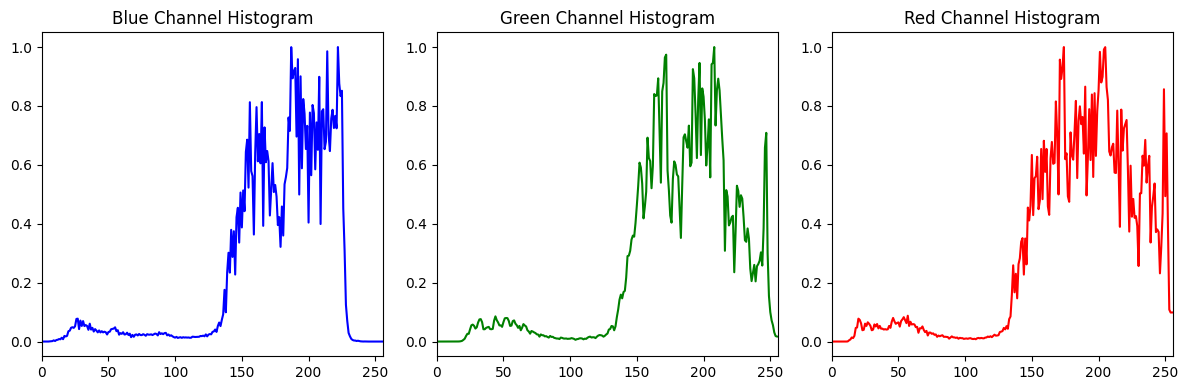

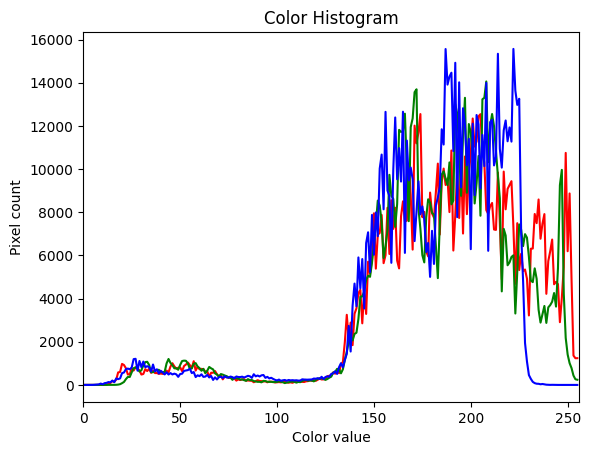

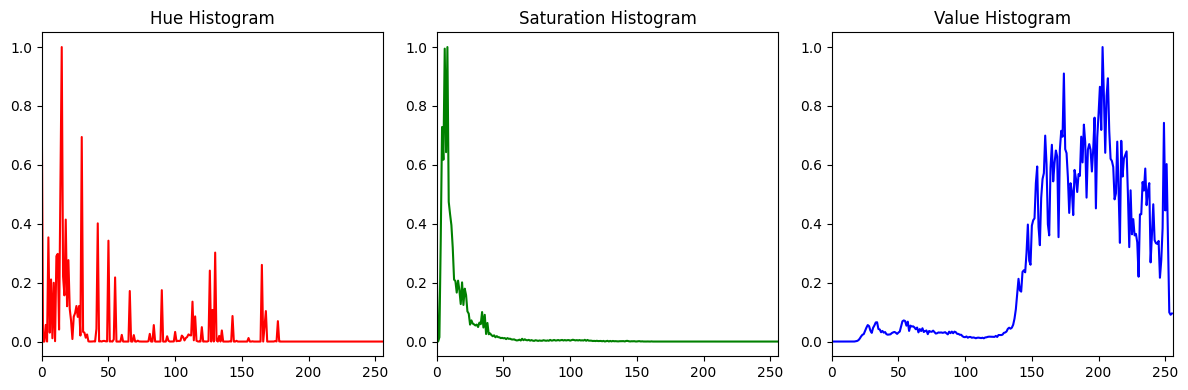

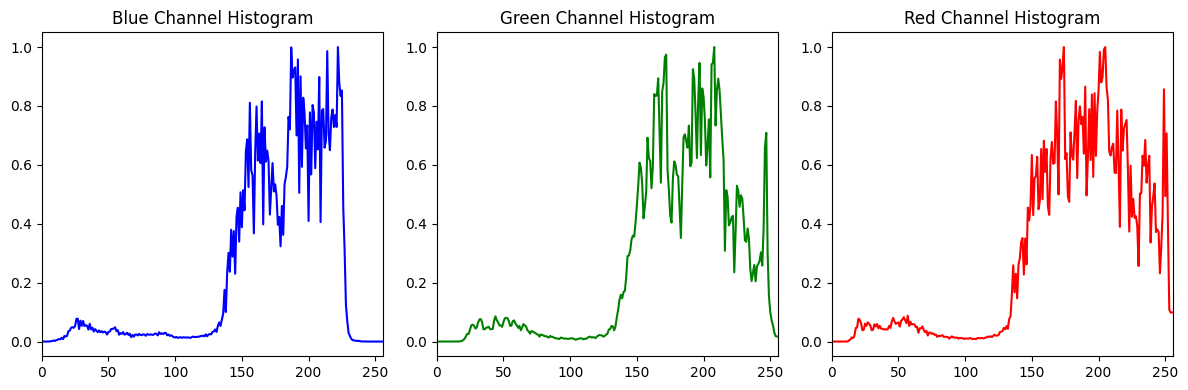

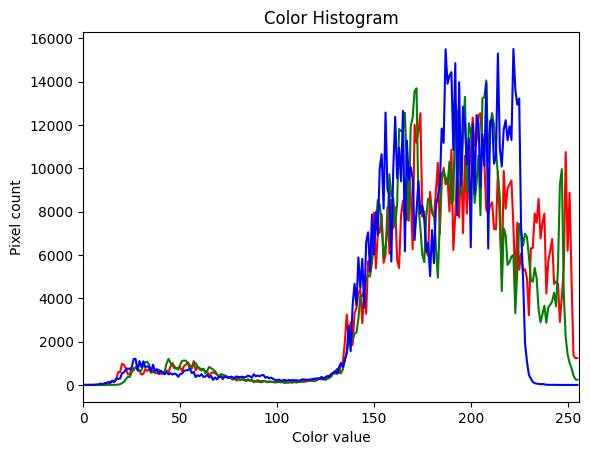

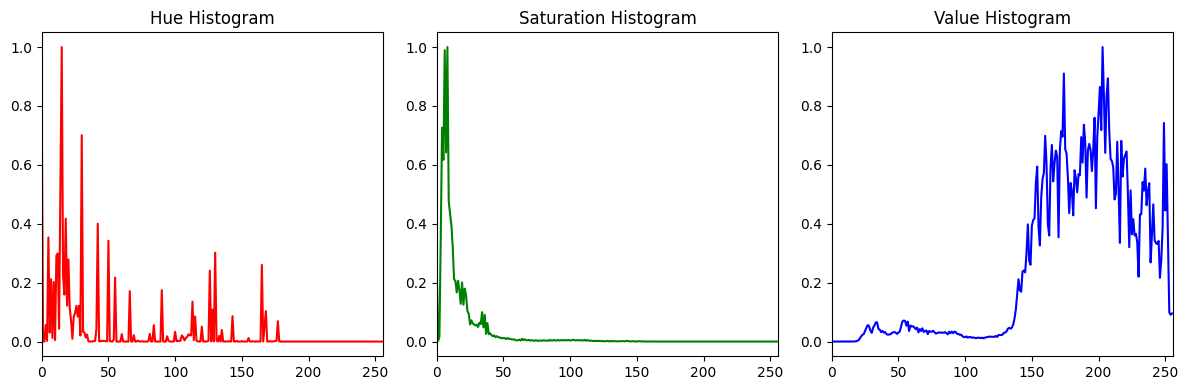

In [23]:
analyse(frames_used)